### NLP with Disaster Tweets
This Kaggle challenge is a binary classification task to predict whether a given tweet relates to a real disaster or not. This involves applying natural language processing (NLP) techniques to analyze the content of the tweets and classify them as either disaster-related or not disaster-related.

#### The data
This dataset contains 10,000 tweets and 5 columns. Each of the training data entries have been manually labeled as either disaster-related or not. These are the column names and definitions:
- id: Unique identifier for each tweet.
- keyword: A keyword from the tweet that might give insight into whether it is disaster-related. This field may contain missing values.
- location: Information about where the tweet originated, although this field is often incomplete or noisy.
- text: The actual content of the tweet, which forms the main data for the task. Tweets are written in various styles, may include slang, typos, emojis, or URLs, making NLP processing challenging.
- target: The label indicating if the tweet is about a disaster (1 for disaster-related, 0 for not disaster-related).

In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

# Load the data
file_path = 'data/train.csv'
data = pd.read_csv(file_path)
data.head(100)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
95,137,accident,Charlotte,9 Mile backup on I-77 South...accident blockin...,1
96,138,accident,"Baton Rouge, LA",Has an accident changed your life? We will hel...,0
97,139,accident,"Hagerstown, MD",#BREAKING: there was a deadly motorcycle car a...,1
98,141,accident,"Gloucestershire , UK",@flowri were you marinading it or was it an ac...,0


It looks like keyword and location may be columns containing all Nulls. Let's do a bit more exploration before we decide to delete those columns.

In [43]:
# Checking for missing values
data.info()
missing_values = data.isnull().sum()
print(missing_values)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB
id             0
keyword       61
location    2533
text           0
target         0
dtype: int64


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            7613 non-null   int64 
 1   keyword       7552 non-null   object
 2   location      5080 non-null   object
 3   text          7613 non-null   object
 4   target        7613 non-null   int64 
 5   tweet_length  7613 non-null   int64 
dtypes: int64(3), object(3)
memory usage: 357.0+ KB


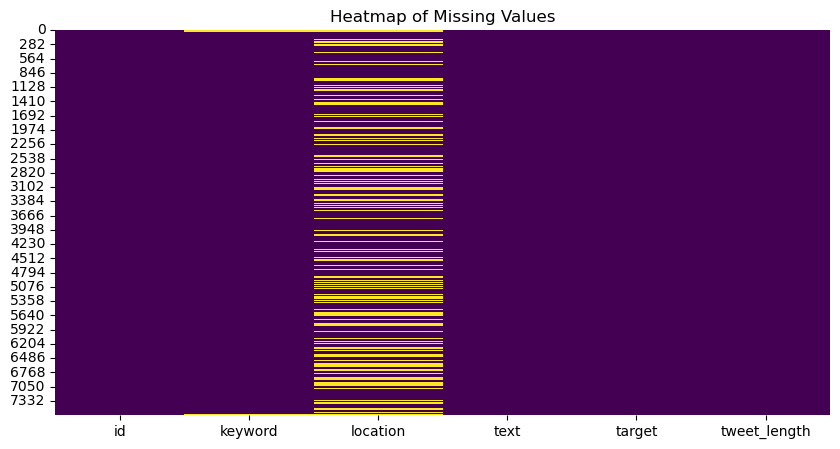

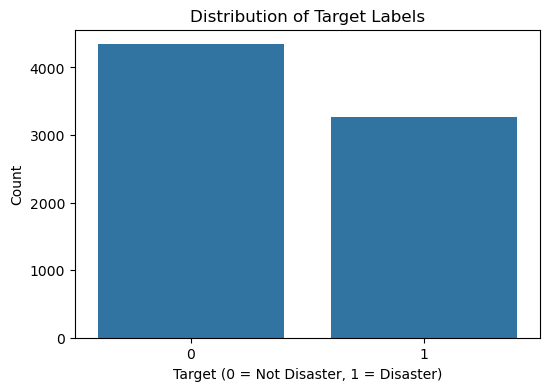

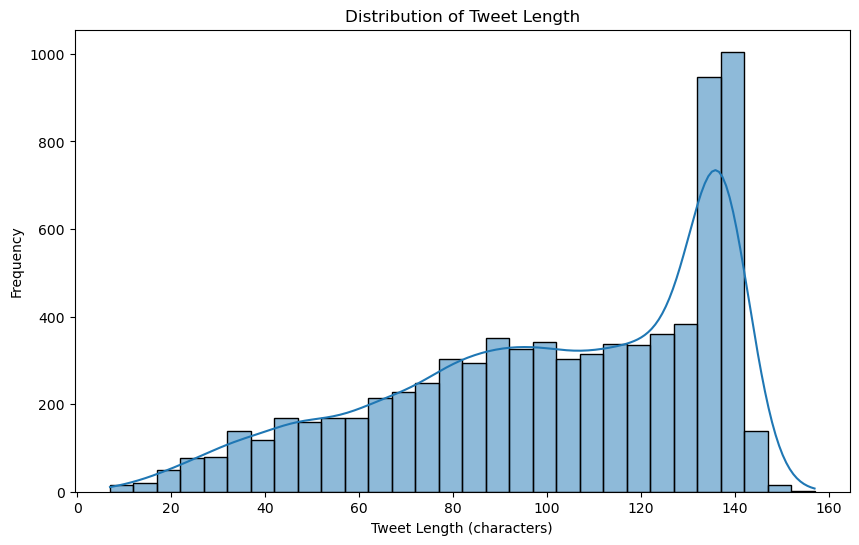

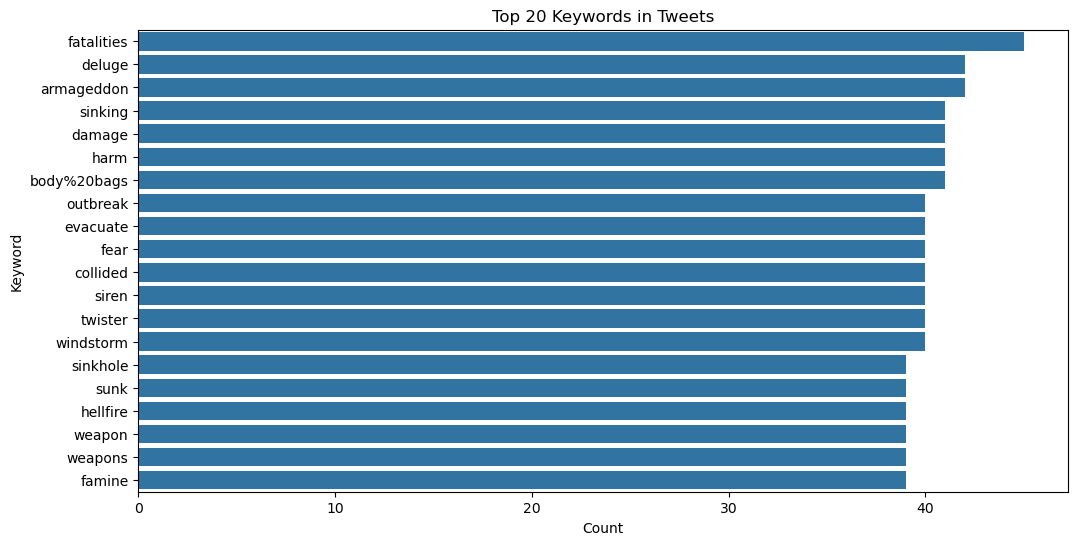

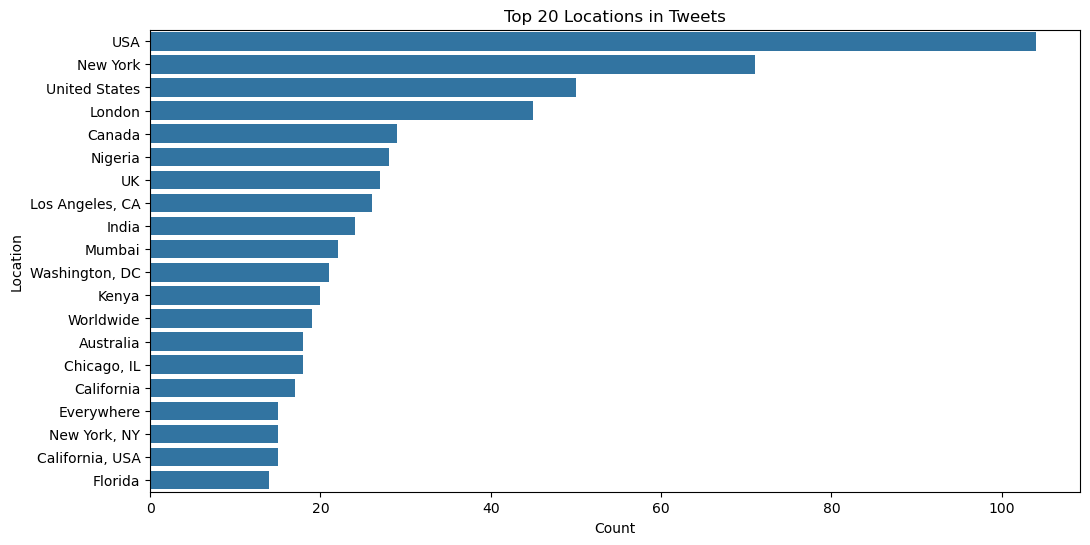

id                 0
keyword           61
location        2533
text               0
target             0
tweet_length       0
dtype: int64

In [45]:
data.info()

missing_values = data.isnull().sum()

# Visualize missing
plt.figure(figsize=(10, 5))
sns.heatmap(data.isnull(), cbar=False, cmap='viridis')
plt.title('Heatmap of Missing Values')
plt.show()

# Plot target distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='target', data=data)
plt.title('Distribution of Target Labels')
plt.xlabel('Target (0 = Not Disaster, 1 = Disaster)')
plt.ylabel('Count')
plt.show()

# Visualizing length of the tweets
data['tweet_length'] = data['text'].apply(len)
plt.figure(figsize=(10, 6))
sns.histplot(data['tweet_length'], bins=30, kde=True)
plt.title('Distribution of Tweet Length')
plt.xlabel('Tweet Length (characters)')
plt.ylabel('Frequency')
plt.show()

# Visualize the number of tweets per keyword
plt.figure(figsize=(12, 6))
sns.countplot(y='keyword', data=data, order=data['keyword'].value_counts().index[:20])
plt.title('Top 20 Keywords in Tweets')
plt.xlabel('Count')
plt.ylabel('Keyword')
plt.show()

# Visualizing the number of tweets per location
plt.figure(figsize=(12, 6))
sns.countplot(y='location', data=data, order=data['location'].value_counts().index[:20])
plt.title('Top 20 Locations in Tweets')
plt.xlabel('Count')
plt.ylabel('Location')
plt.show()

# Display the number of missing values per column
missing_values


I will drop the location field because of the number of nulls. The keyword is also missing any semantic meaning so I will drop the keyword column as well

### Data cleaning
I didn't want to have to download the NLTK corpus so I went with a simple regex cleaning approach. Let's see how it works out for me.

In [46]:
data_cleaned = data.drop(columns=['keyword', 'location'])

def simple_clean_text(text):
    # Clean out URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Remove special characters
    text = re.sub(r'[^A-Za-z\s]', '', text)
    # Lowercase
    text = text.lower()
    return text

data_cleaned['cleaned_text'] = data_cleaned['text'].apply(simple_clean_text)
data_cleaned[['text', 'cleaned_text']].head()


,text,cleaned_text
0,Our Deeds are the Reason of this #earthquake M...,our deeds are the reason of this earthquake ma...
1,Forest fire near La Ronge Sask. Canada,forest fire near la ronge sask canada
2,All residents asked to 'shelter in place' are ...,all residents asked to shelter in place are be...
3,"13,000 people receive #wildfires evacuation or...",people receive wildfires evacuation orders in...
4,Just got sent this photo from Ruby #Alaska as ...,just got sent this photo from ruby alaska as s...


### EDA results
- The dataset consists of 10,000 rows and 3 main columns: id, text, and target.
- The keyword, location, had many nulls and both columns will not have an effect on our model. So I dropped them.
- A histogram was generated to understand the distribution of tweet lengths. Most tweets are within a reasonable length for Twitter, but understanding this helps in deciding how to truncate or pad sequences during preprocessing.

### Plan of analysis
- Clean the tweet text by removing URLs, punctuation, special characters, and converting text to lowercase
- Remove stop words and potentially use stemming or lemmatization to standardize the words.
- Convert the cleaned tweet text into numerical representations using techniques such as Bag of Words, TF-IDF, or Word Embeddings (e.g., Word2Vec or GloVe)
- Train different machine learning models such as Logistic Regression, Random Forest, or Naive Bayes on the extracted features.
Additionally, experiment with deep learning models like LSTMs or BERT for potential better accuracy.
- Split the dataset into training and validation sets to evaluate model performance.
Use accuracy, precision, recall, and F1 score as metrics to evaluate the model’s capability.

### Data extraction using TD-IDF
TF-IDF helps to reduce the importance of very common words (like "the", "and") across the corpeus. This reduces the noise in the dataset and makes it easier to train the model on the more meaningful words. It allows us to identify key terms from each document and focus on those that are more likely to provide insightgs on whether a tweet is related to a disaster.

In [47]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize the TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=500, stop_words='english')

# Fit and transform the cleaned text data
tfidf_features = tfidf_vectorizer.fit_transform(data_cleaned['cleaned_text'])

# Convert to a DataFrame for better visualization
tfidf_df = pd.DataFrame(tfidf_features.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

# Display the TF-IDF features DataFrame
tfidf_df.head()

,abc,ablaze,accident,actually,affected,ago,air,airplane,airport,ambulance,...,wreckage,wrecked,year,yearold,years,yes,youre,youtube,yr,zone
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Logistic regression

In [48]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Splitting the dataset into training and test sets
X = tfidf_df  # TF-IDF features
y = data_cleaned['target']  # Target labels

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize Logistic Regression model
logistic_model = LogisticRegression()

# Train the model
logistic_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = logistic_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

# Display results
print(f"Accuracy: {accuracy:.2f}")
print("\nConfusion Matrix:")
print(confusion)
print("\nClassification Report:")
print(report)


Accuracy: 0.78

Confusion Matrix:
[[755 119]
 [213 436]]

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.86      0.82       874
           1       0.79      0.67      0.72       649

    accuracy                           0.78      1523
   macro avg       0.78      0.77      0.77      1523
weighted avg       0.78      0.78      0.78      1523



These results suggest that the logistic regression model is performing reasonably well on the full dataset, with an overall accuracy of 78%. Here are a few observations:

Class 0 (Not Disaster) is predicted quite well, with a precision of 0.78 and a recall of 0.86.
Class 1 (Disaster) has lower performance, with a recall of 0.67, indicating that some disaster-related tweets are being missed.
Precision and F1 Score for class 1 are also reasonable, but there is room for improvement.

### Parameter tuning

In [49]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for Logistic Regression
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  # Regularization
    'penalty': ['l1', 'l2'],       # Regularization types
    'solver': ['liblinear', 'saga'] # Solvers
}

logistic_model = LogisticRegression(max_iter=1000)

# Use GridSearchCV to find search the best hyperparameteers
grid_search = GridSearchCV(logistic_model, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)

grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
best_score = grid_search.best_score_

best_params, best_score

Fitting 5 folds for each of 20 candidates, totalling 100 fits


/Users/John/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


({'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}, 0.7798029556650247)

### Results of hyperparameter tuning
Use the best hyperparameters (C=1, penalty='l1', solver='liblinear') to retrain the model on the entire training set.

In [30]:
# Retrain the Logistic Regression model with the best parameters obtained from Grid Search
logistic_model_best = LogisticRegression(C=1, penalty='l1', solver='liblinear', max_iter=300)

# Fit the model to the training data
logistic_model_best.fit(X_train, y_train)

# Make predictions on the test set
y_pred_best = logistic_model_best.predict(X_test)

# Evaluate the retrained model
accuracy_best = accuracy_score(y_test, y_pred_best)
confusion_best = confusion_matrix(y_test, y_pred_best)
report_best = classification_report(y_test, y_pred_best)

# Display the evaluation results
accuracy_best, confusion_best, report_best


(0.7741300065659882,
 array([[758, 116],
        [228, 421]]),
 '              precision    recall  f1-score   support\n\n           0       0.77      0.87      0.82       874\n           1       0.78      0.65      0.71       649\n\n    accuracy                           0.77      1523\n   macro avg       0.78      0.76      0.76      1523\nweighted avg       0.78      0.77      0.77      1523\n')

### Analysis of hyperparameter tuning
The baseline model seems to perform slightly better overall, particularly in classifying disaster-related tweets (class 1), as it has higher recall and F1 score for that class. So far my baseline model outperforms the tuning of hyperparameters

### Random forest
The baseline logistic regression model outperformed this random forest model. I will also tune the hyperparameters of the random forest to see if we can beat the baseline logistic regression model.

In [50]:
from sklearn.ensemble import RandomForestClassifier

random_forest_model = RandomForestClassifier(n_estimators=100, random_state=42)
random_forest_model.fit(X_train, y_train)

y_pred_rf = random_forest_model.predict(X_test)

accuracy_rf = accuracy_score(y_test, y_pred_rf)
confusion_rf = confusion_matrix(y_test, y_pred_rf)
report_rf = classification_report(y_test, y_pred_rf)

accuracy_rf, confusion_rf, report_rf


(0.747866053841103,
 array([[702, 172],
        [212, 437]]),
 '              precision    recall  f1-score   support\n\n           0       0.77      0.80      0.79       874\n           1       0.72      0.67      0.69       649\n\n    accuracy                           0.75      1523\n   macro avg       0.74      0.74      0.74      1523\nweighted avg       0.75      0.75      0.75      1523\n')

In [51]:
### Random forest hyperparameter tuning

In [52]:
from sklearn.model_selection import RandomizedSearchCV

param_grid_rf = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [None, 10, 20, 30, 40],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False],
    'class_weight': ['balanced', 'balanced_subsample', None]
}

random_forest_model = RandomForestClassifier(random_state=42)
random_search_rf = RandomizedSearchCV(random_forest_model, param_grid_rf, n_iter=10, cv=3, scoring='accuracy', n_jobs=-1, verbose=2, random_state=42)
random_search_rf.fit(X_train, y_train)

best_params_rf = random_search_rf.best_params_
best_score_rf = random_search_rf.best_score_

best_params_rf, best_score_rf


Fitting 3 folds for each of 10 candidates, totalling 30 fits


({'n_estimators': 200,
  'min_samples_split': 5,
  'min_samples_leaf': 1,
  'max_depth': 40,
  'class_weight': 'balanced_subsample',
  'bootstrap': True},
 0.7568144499178983)

### Results and analysis
Baseline Logistic Regression performed the best in terms of accuracy (78%) and F1 score for disaster-related tweets (0.72). It demonstrated the most balanced performance across both classes, with good precision and recall.
The Tuned Logistic Regression model had slightly lower accuracy (77.41%), and its performance for class 1 dropped compared to the baseline.
The default Random Forest model showed accuracy of 74.79% and struggled more in classifying disaster tweets (class 1). Its F1 score for disaster-related tweets was also slightly lower than Logistic Regression. The Logistic Regression with Class Weighting performed poorly, as it ended up heavily biased towards class 0 and could not correctly classify any disaster tweets. The Tuned Random Forest showed potential improvements with a cross-validation accuracy of 75.68%, but its final evaluation needs to be compared against other models using test data.

### Conclusion
Conclusion:
Baseline Logistic Regression is currently the best performing model based on accuracy, precision, recall, and F1 score.
Tuned Random Forest may be a competitive alternative, but it requires further evaluation to confirm if it can outperform the baseline Logistic Regression on the test set.

### Output for kaggle

In [53]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

logistic_model_best = LogisticRegression(C=1, penalty='l1', solver='liblinear', max_iter=300)
logistic_model_best.fit(X_train, y_train)  # Re-train the best logistic model on full training set
test_predictions = logistic_model_best.predict(test_features)

submission = pd.DataFrame({'id': test_data_cleaned['id'], 'target': test_predictions})

submission_file_path = 'data/submission.csv'
submission.to_csv(submission_file_path, index=False)

submission_file_path


/Users/John/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


'data/submission.csv'

In [54]:
X.head()

,abc,ablaze,accident,actually,affected,ago,air,airplane,airport,ambulance,...,wreckage,wrecked,year,yearold,years,yes,youre,youtube,yr,zone
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
